In [2]:
# Install required libraries
!pip install pandas scikit-learn

# Upload JSON file
from google.colab import files
uploaded = files.upload()

import json
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

Saving user-wallet-transactions.json to user-wallet-transactions.json


In [4]:
# Load the JSON file
filename = list(uploaded.keys())[0]
with open(filename, 'r') as f:
    raw_data = json.load(f)

# Extract necessary fields from nested structure
processed_data = []
for entry in raw_data:
    try:
        wallet = entry['userWallet']
        action = entry['action']
        timestamp = entry['timestamp']
        amount = float(entry['actionData'].get('amount', 0)) / 1e6
        price = float(entry['actionData'].get('assetPriceUSD', 1.0))
        usd_amount = amount * price
        processed_data.append({
            'wallet': wallet,
            'action': action.lower(),
            'amount': usd_amount,
            'timestamp': pd.to_datetime(timestamp, unit='s')
        })
    except Exception as e:
        print(f"Skipping record due to error: {e}")
        continue

df = pd.DataFrame(processed_data)
df.head()

,wallet,action,amount,timestamp
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,1.987664e+03,2021-08-17 05:29:26
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2.856945e+14,2021-05-20 15:36:53
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,9.223773e+08,2021-07-24 09:28:33
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,4.229933e+09,2021-07-31 23:15:18
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,5.026161e-01,2021-04-19 15:25:07


In [5]:
# Feature engineering
def extract_features(df):
    features = []
    for wallet, group in df.groupby('wallet'):
        stats = {
            'wallet': wallet,
            'num_deposits': (group['action'] == 'deposit').sum(),
            'num_borrows': (group['action'] == 'borrow').sum(),
            'num_repays': (group['action'] == 'repay').sum(),
            'num_redeems': (group['action'] == 'redeemunderlying').sum(),
            'num_liquidations': (group['action'] == 'liquidationcall').sum(),
            'total_deposit_usd': group.loc[group['action'] == 'deposit', 'amount'].sum(),
            'total_borrow_usd': group.loc[group['action'] == 'borrow', 'amount'].sum(),
            'total_repay_usd': group.loc[group['action'] == 'repay', 'amount'].sum(),
        }
        stats['repay_to_borrow_ratio'] = (
            stats['total_repay_usd'] / stats['total_borrow_usd']
            if stats['total_borrow_usd'] > 0 else 0
        )
        stats['liquidation_ratio'] = (
            stats['num_liquidations'] / stats['num_borrows']
            if stats['num_borrows'] > 0 else 0
        )
        stats['activity_days'] = (group['timestamp'].max() - group['timestamp'].min()).days + 1
        features.append(stats)
    return pd.DataFrame(features)

df_features = extract_features(df)

In [ ]:
# Model and scoring
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
X = df_features.drop(columns=['wallet'])
model.fit(X)

df_features['raw_score'] = model.decision_function(X)
df_features['risk_label'] = model.predict(X)

# Scale score between 0 and 1000
raw = df_features['raw_score']

min_score = raw.min()
max_score = raw.max()
df_features['credit_score'] = (
(raw - min_score) / (max_score - min_score) * 1000
).clip(0, 1000).astype(int)

print(df_features[['wallet', 'raw_score', 'credit_score']].describe())

         raw_score  credit_score
count  3497.000000   3497.000000
mean      0.154689    855.062625
std       0.090029    191.758414
min      -0.247101      0.000000
25%       0.132797    808.000000
50%       0.195944    943.000000
75%       0.220707    996.000000
max       0.222575   1000.000000


In [9]:
# Save and display
df_results = df_features[['wallet', 'credit_score']].sort_values(by='credit_score', ascending=False)
df_results.head(10)

,wallet,credit_score
8,0x000000007858e6f2668e1e06111cfa24403a5466,1000
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1000
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1000
9,0x00000001a0f57e850c9db68b4a9bc34677437c5c,1000
15,0x00000a9c78912badb92d73b6ed26456e11def5eb,1000
3475,0x060cfcf2bd89aadaedd2f2b4760466ec1c57377c,1000
19,0x0000b252c943089fbba5554a1d196ef79bc77e4f,1000
1501,0x02803b28b29a24d895e523fbfa561700e01b09de,1000
1503,0x0280ce4e1add2b66e6fb0588976dec050c141135,1000
1505,0x028179cc3d6dd3e3f98086134062eb1f7236ae1b,1000


In [ ]:
# Save to CSV
df_results.to_csv("wallet_credit_scores.csv", index=False)
files.download("wallet_credit_scores.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

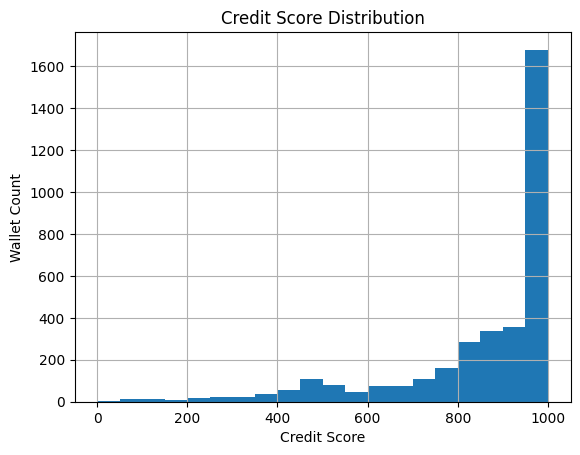

In [12]:
import matplotlib.pyplot as plt
df_features['credit_score'].hist(bins=20)
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()